In [106]:
# Basic imports
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("en_core_web_sm")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter, defaultdict
from contractions_dict import contraction_mapping
import altair as alt
from textblob import TextBlob
from sklearn.metrics import confusion_matrix

In [100]:
# Out of full dataset we are going to take 10% of reviews ie 50000 for analysis
df=pd.read_csv("Reviews.csv",nrows=200000)

# Dropping columns that aren't useful from nlp perspective
df = df.drop(columns=['Id','ProductId', 'UserId', 'ProfileName', 'Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator'], axis=1)

# Dropping duplicates and na 
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)

# Reviews with score 4 and 5 are of positive sentiment and 1,2,3 score are of negative sentiment  
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x in [4,5] else 0 )
pos = df[df['Sentiment']==1][:25000]
neg = df[df['Sentiment']==0][:25000]
df = pd.concat([pos,neg])
# We don't need Score columns anymore
df = df.drop(columns = ['Score'], axis=1)

In [101]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    '''
        Text cleaner does the following
        1. Lowercase text
        2. Removes non text from raw reviews
        3. Substitutes not alphanumeric characters
        4. Correct words using the contractions mapping dictionary
        5. Removes Junk characters generated after cleaning
        6. Remove stop words if num=0 that means for review only not for summary
        
        Parameters: String, Number
        Returns: String
    '''
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                
            long_words.append(i)   
    return (" ".join(long_words)).strip()

# Cleaning raw reviews
cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t,1)) 

# Cleaning review summaries
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

# Create news columns for cleaned data  
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

# Dropping empty rows
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

# Dropping raw summary and review columns 
df = df.drop(columns=['Summary', 'Text'], axis=1)

In [102]:
def aspect_description_extractor(sentence):
    '''
        Aspect description extractors
        1. Parses the sentence with spacy parser
        2. If token is POS is noun and dependence is noun subject
        3. Then it considers that token as aspect of review
        4. If POS of token is adjective and child token POS is adverb 
        5. Then added children token and tokes as descrition
        
        Parameters: String
        Returns: Dict
    '''
    result = []
    doc = nlp(sentence)
    descriptive_term = ''
    target = ''
    for token in doc:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
        if token.pos_ == 'ADJ':
            prepend = ''
            for child in token.children:
                if child.pos_ != 'ADV':
                    continue
                prepend += child.text + ' '
            descriptive_term = prepend + token.text
    result.append({'aspect': target,'description': descriptive_term})
    return result

# Applying extractor to cleaned text
df['result'] = df['cleaned_text'].apply(lambda x: aspect_description_extractor(x))

# Creating new columns for aspect and description
df['aspect'] = df['result'].apply(lambda x: x[0]['aspect'])
df['description'] = df['result'].apply(lambda x: x[0]['description'])
df['predicted_sentiment'] = df['description'].apply(lambda x: 1 if TextBlob(x).sentiment.polarity>0 else 0)

In [103]:
top_aspects = df['aspect'].value_counts().head(10).index
temp1 = df[df['aspect'].isin(top_aspects)].groupby(['aspect', 'Sentiment']).size().reset_index(name='count')
alt.Chart(temp1, title='Aspect extracted from product reviews').mark_bar().encode(
    alt.X('Sentiment:O'),
    alt.Y("count"),
    color='Sentiment:N',
    column='aspect'
).properties(width=60)

alt.Chart(...)

In [104]:
top_descriptions = df['description'].value_counts().head(10).index
temp2 = df[df['description'].isin(top_descriptions)].groupby(['description', 'Sentiment']).size().reset_index(name='count')
alt.Chart(temp2, title='Descriptions extracted from product reviews').mark_bar().encode(
    alt.X('Sentiment:O'),
    alt.Y("count"),
    color='Sentiment:N',
    column='description'
).properties(width=60)

alt.Chart(...)

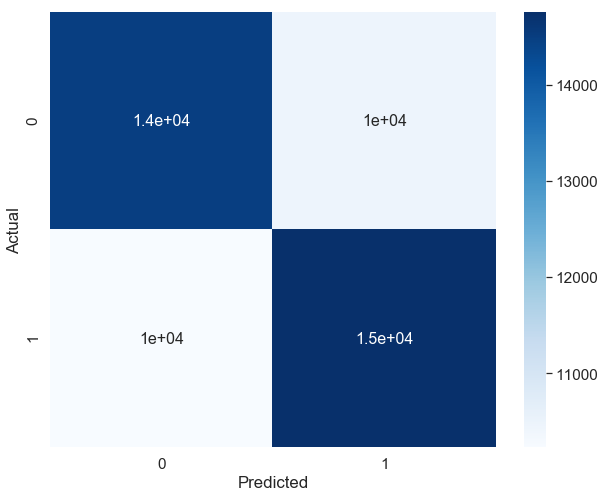

In [113]:
data = confusion_matrix(df['Sentiment'], df['predicted_sentiment'])
df_cm = pd.DataFrame(data, columns=np.unique(df['Sentiment']), index = np.unique(df['predicted_sentiment']))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

### Can we do better aspect and sentiment extraction?

In [115]:
neg_file = open("neg_words.txt",encoding = "ISO-8859-1")
pos_file = open("pos_words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos

def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''

    sent_dict = Counter()
    sentence = nlp(sentence)
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                sent_dict[token.head.text] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):                        
                        sent_dict[child.text] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.text)
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    noun = ""
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"): 
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.text
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.text + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return dict(sent_dict)

In [116]:
df['results2'] = df['cleaned_text'].apply(lambda x: feature_sentiment(x))

In [160]:
def getList(dict):
    return dict.keys()

result = []
for key, value in df['results2'].iteritems():
    keys = getList(value)
    for i in list(keys):
        result.append(i)
        
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud().generate(' '.join(result))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

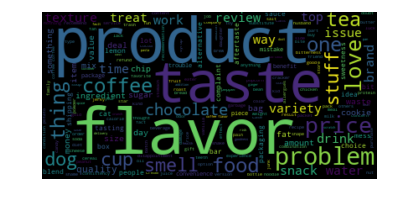

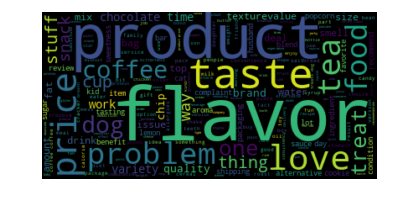

In [168]:
def getList(dict):
    return dict.keys()

positive = []
for key, value in df[df['Sentiment']==1]['results2'].iteritems():
    keys = getList(value)
    for i in list(keys):
        positive.append(i)
        
wordcloud = WordCloud().generate(' '.join(positive))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

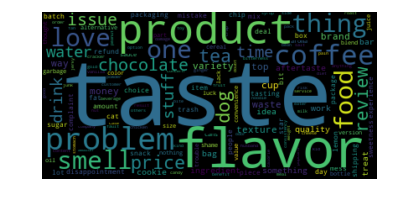

In [169]:
def getList(dict):
    return dict.keys()

negative = []
for key, value in df[df['Sentiment']==0]['results2'].iteritems():
    keys = getList(value)
    for i in list(keys):
        negative.append(i)
        
wordcloud = WordCloud().generate(' '.join(negative))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [171]:
df = df.rename(columns={'results2':'granular_aspect'})
df = df.drop(['cleaned_summary', 'result'], axis=1)

In [172]:
df.head()

,Sentiment,cleaned_text,aspect,description,predicted_sentiment,granular_aspect
0,1,have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like stew than processed meat and it smells better my labrador is ...,labrador,most,1,"{'quality': 1, 'product': 2.5, 'stew': -1, 'labrador': -1}"
2,1,this is confection that has been around few centuries it is light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sug...,,familiar,1,{'yummy': 1}
4,1,great taffy at great price there was wide assortment of yummy taffy delivery was very quick if your taffy lover this is deal,lover,very quick,1,"{'taffy': 1, 'price': 1, 'taffy lover': 1, 'deal': 1}"
5,1,got wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was bit too mu...,weeks,delightful,1,"{'hair': -1, 'taffy': 1, 'complaint': -1, 'brand': 1, 'weeks': 1, 'treat': 1}"
6,1,this saltwater taffy had great flavors and was very soft and chewy each candy was individually wrapped well none of the candies were stuck together which did happen in the expensive version fralin...,candy,expensive,0,"{'flavors': 1, 'none': 1, 'candy': -1, 'fralinger': -1, 'it': 1}"
